# Generating MNIST Digit Images using GAN and CGAN

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding, Multiply, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Data

In [ ]:
# Data Loading
(Xtrain, ytrain), (_, _) = mnist.load_data()
# Rescale between -1 and 1
Xtrain = Xtrain / 127.5 - 1.
Xtrain = np.expand_dims(Xtrain, axis=3)
ytrain = ytrain.reshape(-1,1)

We obtain a tensor of 60 000 images of size 28 by 28 with only 1 channel. 

In [ ]:
Xtrain.shape

(60000, 28, 28, 1)

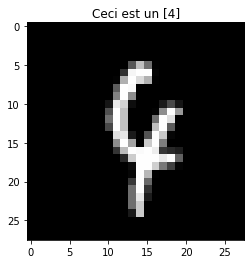

In [ ]:
i = np.random.randint(0,Xtrain.shape[0])
img_s = Xtrain[i,:,:,0]
p=plt.imshow(img_s,cmap='gray')
t=plt.title("Ceci est un {}".format(ytrain[i]))

# GAN

We will use these images to create a GAN capable of generating realistic handwritten digit images. 

In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Construction and compilation of the disciminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Construction of the generator
        self.generator = self.build_generator()

        # To optimize the parameters of the generator we must couple it to the discriminator
        # The model combined by a random vector in the latent space
        z = Input(shape=(self.latent_dim,))
        # it generate an image with the genarator
        img = self.generator(z)

        # and send it with the discriminator
        validity = self.discriminator(img)

       
        self.combined = Model(z, validity)
        
        # To optimise the generator, the weights need to be fixed
        self.discriminator.trainable = False
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    def build_generator(self):
        
        # Generator : keras model based on 8 layers
        
        z = Input(shape=(self.latent_dim,))
        
        model = Sequential()
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.img_rows*self.img_cols,activation='tanh'))
        model.add(Reshape(self.img_shape))
        
        img = model(z)
        
        
        return Model(z, img)

    def build_discriminator(self):

        # Discriminator : keras model
        
        
        img = Input(shape=self.img_shape)
        model=Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        validity = model(img)
        
        # it produces a number called 'validity' between [0,1] 0 image produced by the generator, 1 real image  
        
        return Model(img, validity)

    def train(self,X_train, epochs, batch_size=128, sample_interval=50):


        # labels vectors
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

        

            indices = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[indices]

            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            generateur_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(generateur_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

          
            noise1 = np.random.normal(0, 1, (batch_size, self.latent_dim))

            
       
            g_loss = self.combined.train_on_batch(noise1, valid)

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f,  acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0],100*d_loss[1]))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1

## GAN expérience 


0 [D loss: 0.465638, acc.: 53.12%] [G loss: 0.550328,  acc.: 53.12%]


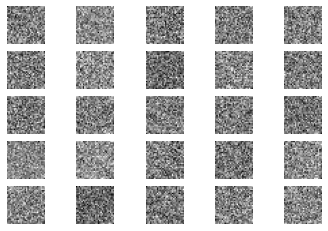

In [ ]:
gan = GAN()
gan.train(Xtrain,epochs=200, batch_size=32, sample_interval=200)

0 [D loss: 1.060284, acc.: 29.69%] [G loss: 0.685811,  acc.: 29.69%]
1000 [D loss: 0.676366, acc.: 53.12%] [G loss: 0.847159,  acc.: 53.12%]
2000 [D loss: 0.594504, acc.: 68.75%] [G loss: 0.961419,  acc.: 68.75%]
3000 [D loss: 0.648389, acc.: 57.81%] [G loss: 0.984489,  acc.: 57.81%]
4000 [D loss: 0.612268, acc.: 64.06%] [G loss: 0.908631,  acc.: 64.06%]
5000 [D loss: 0.712521, acc.: 53.12%] [G loss: 0.916383,  acc.: 53.12%]
6000 [D loss: 0.607718, acc.: 65.62%] [G loss: 0.892619,  acc.: 65.62%]
7000 [D loss: 0.636852, acc.: 60.94%] [G loss: 0.899659,  acc.: 60.94%]
8000 [D loss: 0.577259, acc.: 70.31%] [G loss: 0.902233,  acc.: 70.31%]
9000 [D loss: 0.620843, acc.: 57.81%] [G loss: 0.937760,  acc.: 57.81%]
10000 [D loss: 0.626339, acc.: 64.06%] [G loss: 0.942821,  acc.: 64.06%]
11000 [D loss: 0.690368, acc.: 54.69%] [G loss: 0.934752,  acc.: 54.69%]
12000 [D loss: 0.668404, acc.: 59.38%] [G loss: 0.960660,  acc.: 59.38%]
13000 [D loss: 0.668802, acc.: 57.81%] [G loss: 0.908525,  acc.:

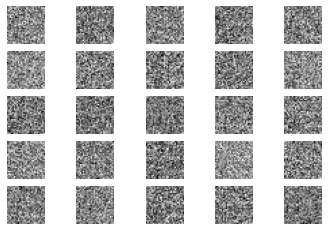

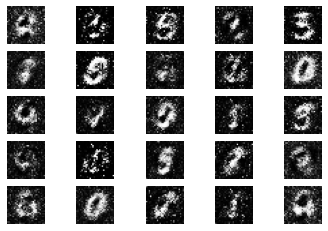

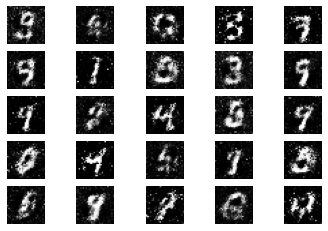

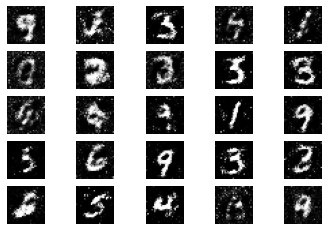

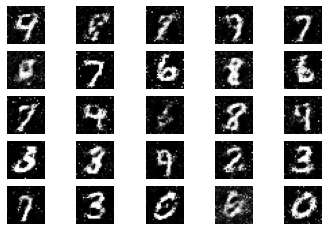

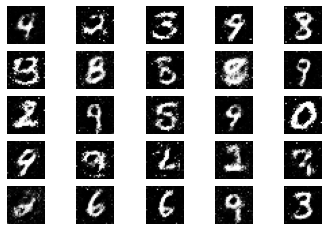

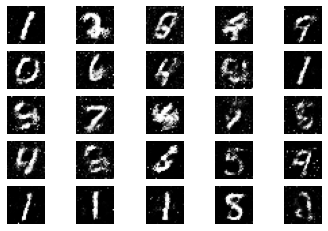

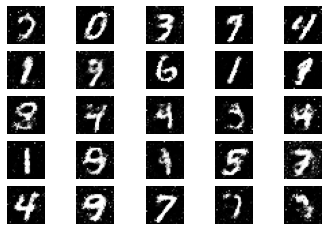

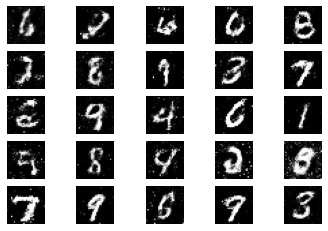

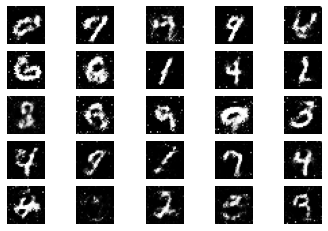

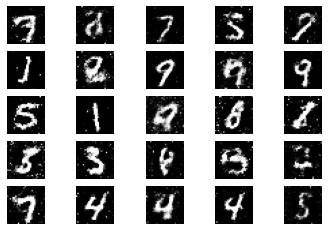

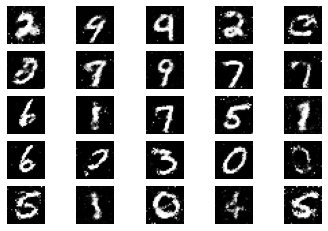

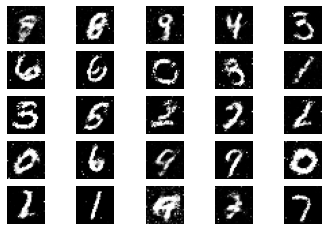

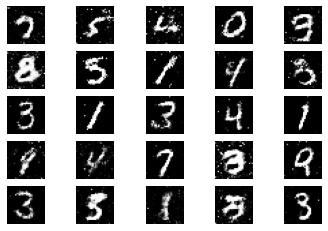

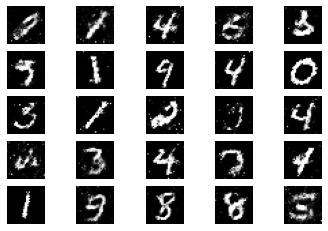

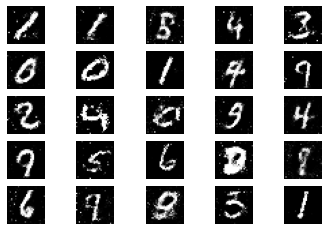

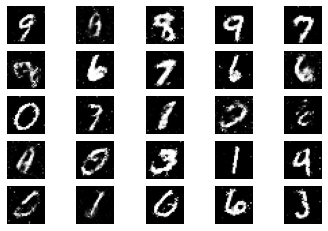

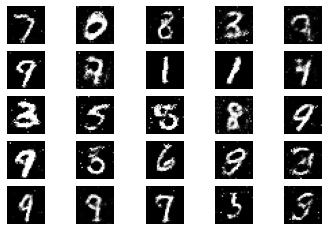

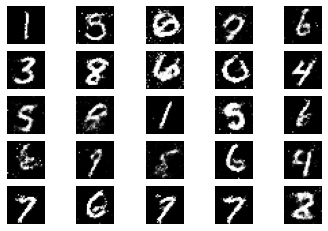

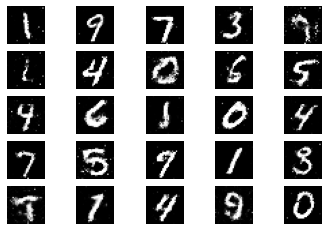

In [ ]:
gan = GAN()
gan.train(Xtrain,epochs=20000, batch_size=32, sample_interval=1000)

# CGAN

We will now use these images and their labels to create a conditional GAN capable of generating realistic handwritten digit images from an input digit. 

In [ ]:
class CGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        # nbr of classess
        self.num_classes = 10

        optimizer = Adam(0.0002, 0.5)

        # Construction and compilation of the disciminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Construction of the generator
        self.generator = self.build_generator()

        # To optimize the parameters of the generator we must couple it to the discriminator
        # The combined model starts with a random vector in the latent space ! and a label !
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        
        # it generate an image with the genarator
        img = self.generator([z,label])

        # and send it with the discriminator
        validity = self.discriminator([img, label])

        
        self.combined = Model([z,label], validity)
        # To optimise the generator, the weights need to be fixed
        self.discriminator.trainable = False
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

    def build_generator(self):

        # Generator : keras model
        
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        
        label_embed = Flatten()(Embedding(self.num_classes, np.prod(self.latent_dim))(label))
        joined_labelz = multiply([z, label_embed])
        
        model = Sequential()
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.img_rows*self.img_cols,activation='tanh'))
        model.add(Reshape(self.img_shape))
        
        img = model(joined_labelz)

        return Model([z, label], img)

    def build_discriminator(self):

        
        # Disciminator: keras model
        # it takes in a size image (self.img_rows, self.img_cols, self.channels) and a label
        
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        joinedinput = multiply([flat_img, label_embedding])

        
        
        # it produces a number between [0,1] : 0 image produced by the generator, 1 real image (validity)
        
        model=Sequential()
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        validity = model(joinedinput)

        return Model([img, label], validity)

    def train(self,X_train, y_train, epochs, batch_size=128, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

           
            indices = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[indices]
            label_imgs=y_train[indices]
            

         
            
            z = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict([z, label_imgs])

            
            d_loss_real = self.discriminator.train_on_batch([imgs, label_imgs], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, label_imgs], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            
           
            Z = np.random.normal(0, 1, (batch_size, self.latent_dim))
            labels = np.random.randint(0, 9, batch_size)
            
          
            g_loss = self.combined.train_on_batch([Z,labels], valid)

         
            if epoch % sample_interval == 0:

                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1

## CGAN Test 

0 [D loss: 0.698888, acc.: 18.75%] [G loss: 0.684244]
200 [D loss: 0.452446, acc.: 75.00%] [G loss: 4.441376]
400 [D loss: 0.616721, acc.: 64.06%] [G loss: 1.581120]
600 [D loss: 0.513362, acc.: 67.19%] [G loss: 1.729601]
800 [D loss: 0.441276, acc.: 76.56%] [G loss: 1.463031]


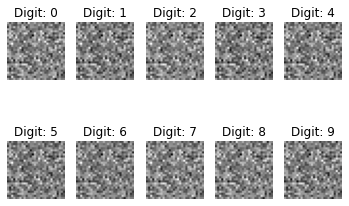

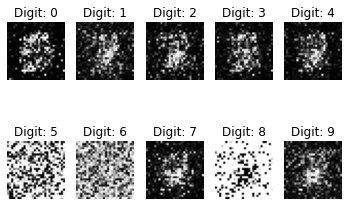

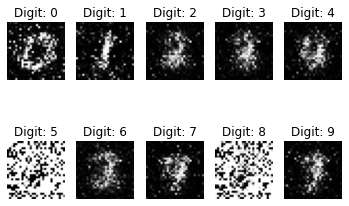

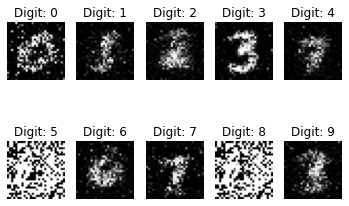

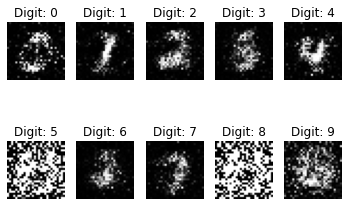

In [ ]:
gan = CGAN()
gan.train(Xtrain,ytrain,epochs=1000, batch_size=32, sample_interval=200)

0 [D loss: 0.700373, acc.: 10.94%] [G loss: 0.690671]
200 [D loss: 0.365690, acc.: 81.25%] [G loss: 4.214074]
400 [D loss: 0.400336, acc.: 85.94%] [G loss: 1.344432]
600 [D loss: 0.499363, acc.: 75.00%] [G loss: 1.493803]
800 [D loss: 0.613443, acc.: 68.75%] [G loss: 1.145650]
1000 [D loss: 0.609425, acc.: 62.50%] [G loss: 1.110918]
1200 [D loss: 0.515183, acc.: 70.31%] [G loss: 1.151662]
1400 [D loss: 0.605463, acc.: 62.50%] [G loss: 1.028133]
1600 [D loss: 0.645344, acc.: 64.06%] [G loss: 1.011959]
1800 [D loss: 0.623146, acc.: 50.00%] [G loss: 0.802299]
2000 [D loss: 0.630971, acc.: 56.25%] [G loss: 0.821622]
2200 [D loss: 0.595457, acc.: 68.75%] [G loss: 0.835744]
2400 [D loss: 0.560375, acc.: 60.94%] [G loss: 0.790735]
2600 [D loss: 0.551184, acc.: 59.38%] [G loss: 0.801007]
2800 [D loss: 0.630373, acc.: 56.25%] [G loss: 0.733550]
3000 [D loss: 0.595098, acc.: 60.94%] [G loss: 0.844287]
3200 [D loss: 0.694230, acc.: 48.44%] [G loss: 0.763256]
3400 [D loss: 0.534004, acc.: 65.62%] 

<ipython-input-71-1289d83036bc>:220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(r, c)


4200 [D loss: 0.680649, acc.: 60.94%] [G loss: 0.726865]
4400 [D loss: 0.650915, acc.: 57.81%] [G loss: 0.762414]
4600 [D loss: 0.554273, acc.: 59.38%] [G loss: 0.752414]
4800 [D loss: 0.572610, acc.: 48.44%] [G loss: 0.762181]
5000 [D loss: 0.630588, acc.: 57.81%] [G loss: 0.794468]
5200 [D loss: 0.623091, acc.: 68.75%] [G loss: 0.700909]
5400 [D loss: 0.617663, acc.: 64.06%] [G loss: 0.779632]
5600 [D loss: 0.588049, acc.: 57.81%] [G loss: 0.762741]
5800 [D loss: 0.686267, acc.: 46.88%] [G loss: 0.700156]
6000 [D loss: 0.596855, acc.: 65.62%] [G loss: 0.785305]
6200 [D loss: 0.577796, acc.: 62.50%] [G loss: 0.752593]
6400 [D loss: 0.617812, acc.: 53.12%] [G loss: 0.681209]
6600 [D loss: 0.605918, acc.: 57.81%] [G loss: 0.766545]
6800 [D loss: 0.606855, acc.: 59.38%] [G loss: 0.727174]
7000 [D loss: 0.671877, acc.: 54.69%] [G loss: 0.743617]
7200 [D loss: 0.587388, acc.: 65.62%] [G loss: 0.752313]
7400 [D loss: 0.594952, acc.: 67.19%] [G loss: 0.723579]
7600 [D loss: 0.606839, acc.: 5

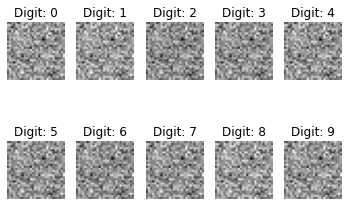

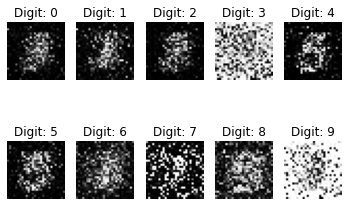

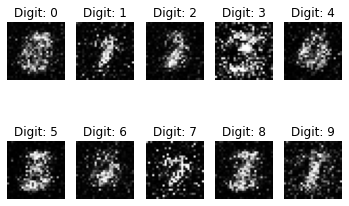

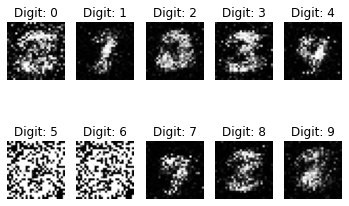

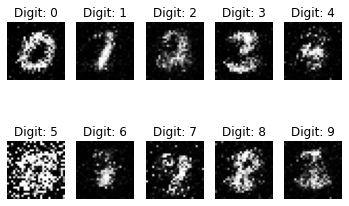

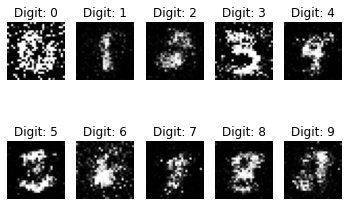

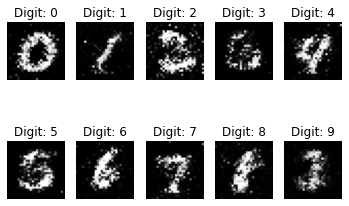

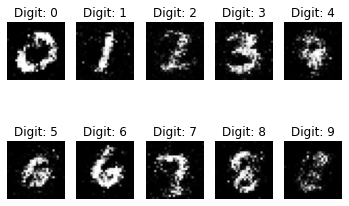

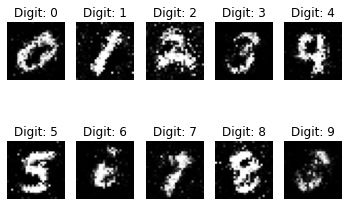

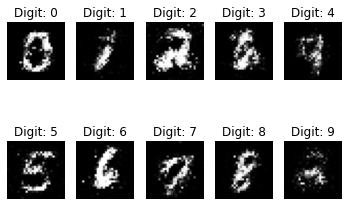

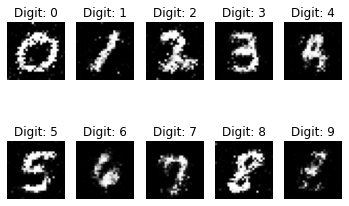

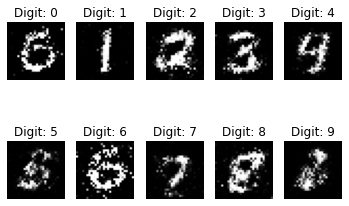

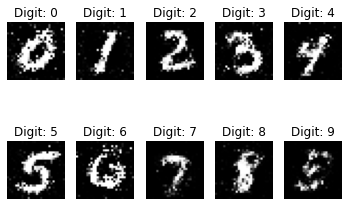

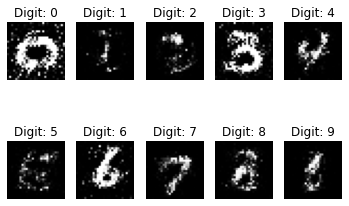

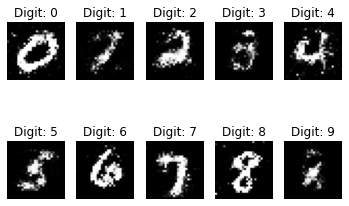

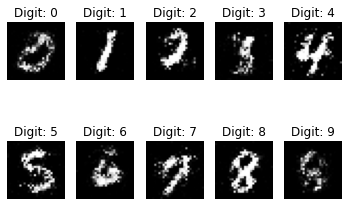

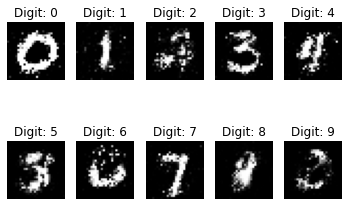

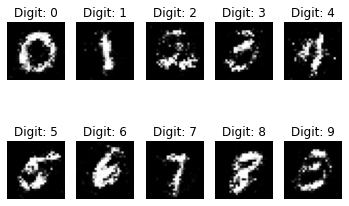

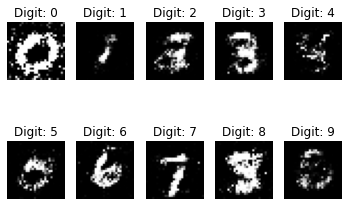

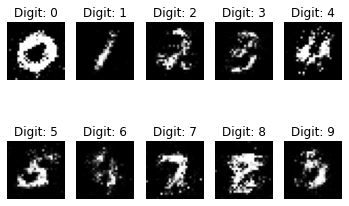

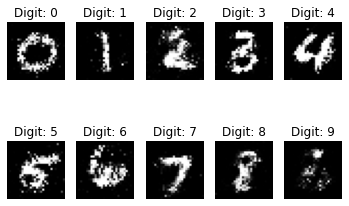

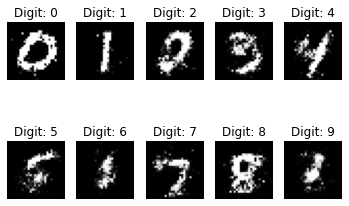

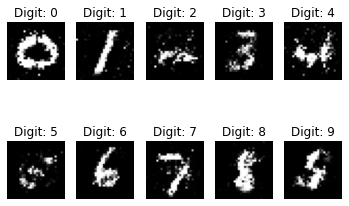

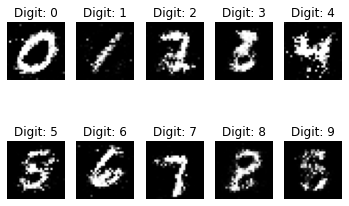

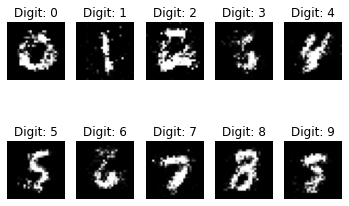

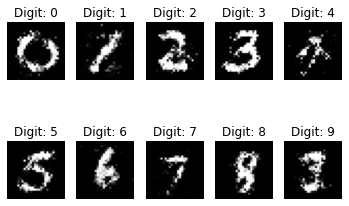

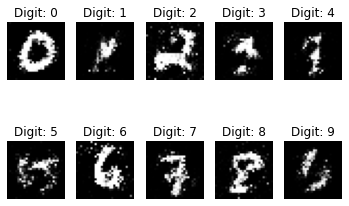

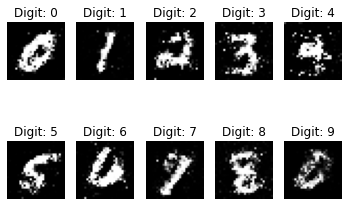

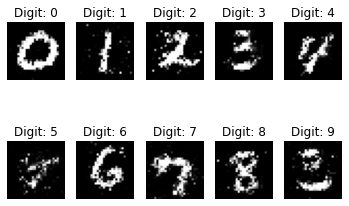

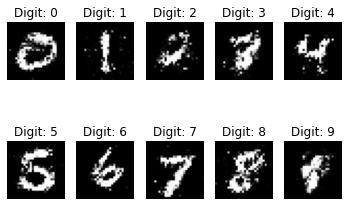

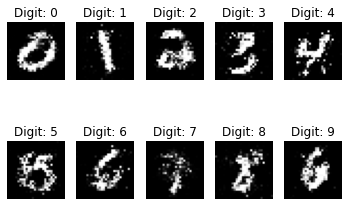

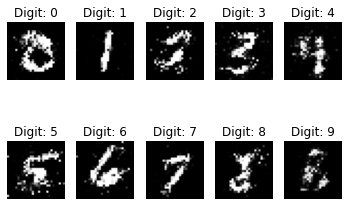

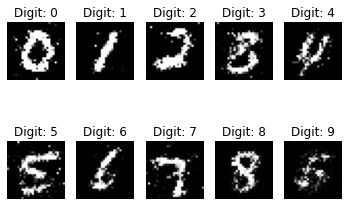

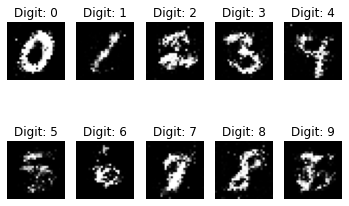

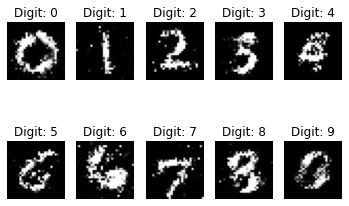

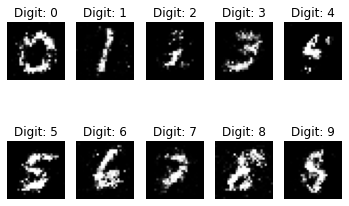

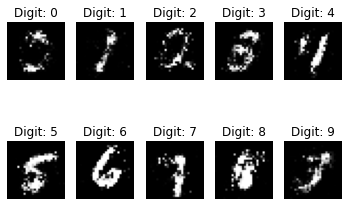

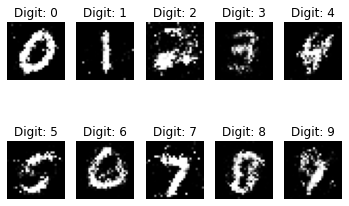

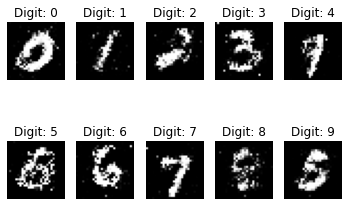

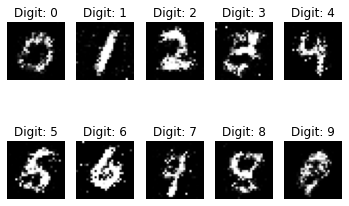

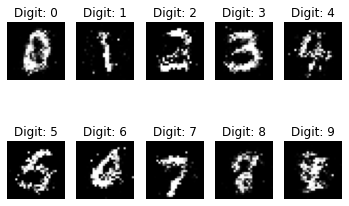

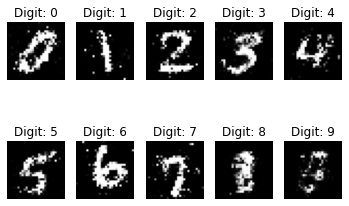

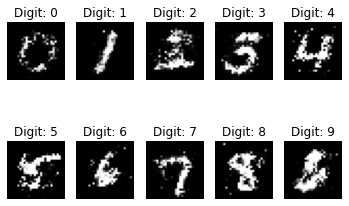

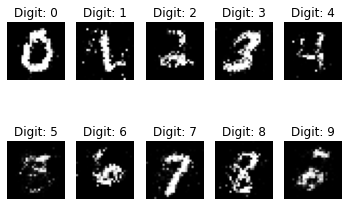

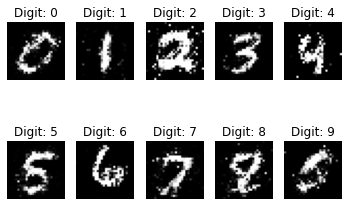

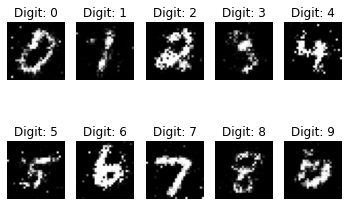

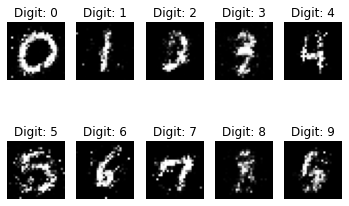

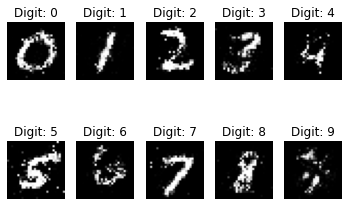

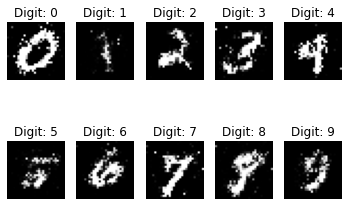

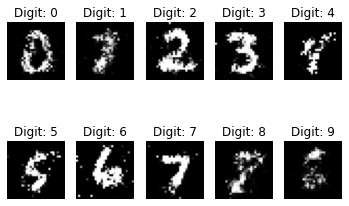

In [ ]:
gan = CGAN()
gan.train(Xtrain,ytrain,epochs=10000, batch_size=32, sample_interval=200)